# Homework week6
## Author: Phuong Thanh Nguyen

In [28]:
# Import packages and paths
from ppi.database import Database
import os
import pandas as pd
from sqlalchemy import create_engine
HOME = os.path.expanduser("~")
PROJECT_FOLDER = os.path.join(HOME, ".ppi")
DB_PATH = os.path.join(PROJECT_FOLDER, "ppi.sqlite")
conn = create_engine(f"sqlite:///{DB_PATH}")

### 1. Read data

In [65]:
# Initiate Database() class 
db = Database()
db.set_path_to_data_file("../tests/data/test_ppi.tsv")
df = db.read_data()
df

,confidence_value,detection_method,a_uniprot_id,b_uniprot_id,interaction_type,pmid,a_name,a_taxid,b_name,b_taxid
0,0.1,dm1,node_id1,node_id2,it1,pmid1,name_1,1,name_2,1
1,0.2,dm2,node_id2,node_id3,it2,pmid1,name_2,1,name_3,1
2,0.3,dm3,node_id2,node_id4,it2,pmid1,name_2,1,name_4,1
3,0.4,dm1,node_id2,node_id5,it2,pmid1,name_2,1,name_5,1
4,0.5,dm4,node_id5,node_id6,it2,pmid1,name_5,1,name_6,2
5,0.6,dm1,node_id2,node_id6,it3,pmid1,name_2,1,name_6,2
6,0.7,dm5,node_id6,node_id7,it3,pmid1,name_6,2,name_7,1
7,0.8,dm2,node_id2,node_id3,it3,pmid1,name_2,1,name_3,1


### 2. Load protein DataFrame

In [68]:
protein = db.get_proteins()
protein

,accession,name,taxid
id,,,
1,node_id1,name_1,1
2,node_id2,name_2,1
3,node_id3,name_3,1
4,node_id4,name_4,1
5,node_id5,name_5,1
6,node_id6,name_6,2
7,node_id7,name_7,1


### 3. Load interaction DataFrame

In [4]:
interaction = db.get_interactions()
interaction

,confidence_value,detection_method,interaction_type,pmid,protein_a_id,protein_b_id
id,,,,,,
1,0.1,dm1,it1,pmid1,1,2
2,0.2,dm2,it2,pmid1,2,3
3,0.3,dm3,it2,pmid1,2,4
4,0.4,dm1,it2,pmid1,2,5
5,0.5,dm4,it2,pmid1,5,6
6,0.6,dm1,it3,pmid1,2,6
7,0.7,dm5,it3,pmid1,6,7
8,0.8,dm2,it3,pmid1,2,3


In [25]:
column = interaction.detection_method
ind = list(column.unique())
number = [column[column == x].count() for x in ind]
df = pd.DataFrame(data = number, index = ind, columns = ["number"])
df.index.name = "detection_method"
df

,number
detection_method,
dm1,3
dm2,2
dm3,1
dm4,1
dm5,1


In [18]:
list(interaction.detection_method.unique())
interaction.detection_method[interaction.detection_method == "dm1"].count()

3

### 4. Check table name in Database()

In [5]:
tables = db.get_table_names()
tables

['protein', 'interaction']

### 5. Column names of protein table in SQL database

In [12]:
protein_col = db.get_columns(table = "protein")
protein_col

['accession', 'name', 'taxid', 'id']

### 6. Column names of interaction table in SQL database

In [14]:
interaction_col = db.get_columns(table = "interaction")
interaction_col

['confidence_value',
 'detection_method',
 'interaction_type',
 'pmid',
 'protein_a_id',
 'protein_b_id',
 'id']

### 7. Check created path of database folder and file

In [17]:
os.path.isdir(PROJECT_FOLDER)

True

In [19]:
os.listdir(PROJECT_FOLDER)

['ppi.sqlite']

### 8. Load tables from SQL database

In [80]:
protein_sql = pd.read_sql_table("protein",conn)
type(protein_sql.columns.tolist())
protein_sql
protein.accession[1]

'node_id1'

In [26]:
interaction_sql = pd.read_sql_table("interaction",conn)
interaction_sql

,id,confidence_value,detection_method,interaction_type,pmid,protein_a_id,protein_b_id
0,1,0.1,dm1,it1,pmid1,1,2
1,2,0.2,dm2,it2,pmid1,2,3
2,3,0.3,dm3,it2,pmid1,2,4
3,4,0.4,dm1,it2,pmid1,2,5
4,5,0.5,dm4,it2,pmid1,5,6
5,6,0.6,dm1,it3,pmid1,2,6
6,7,0.7,dm5,it3,pmid1,6,7
7,8,0.8,dm2,it3,pmid1,2,3


In [27]:
import networkx as nw

In [87]:
def get_where(pmid=False,detection_method=False,interaction_type=False,confidence_value_gte=False,disallow_self_interaction=False):
        where = ""
        if pmid:
            where += f"WHERE pmid = '{pmid}'"
        if detection_method:
            if len(where) == 0:
                where += f"WHERE detection_method = '{detection_method}'"
            else: 
                where += f"AND detection_method = '{detection_method}'"
        if interaction_type:
            if len(where) == 0:
                where += f"WHERE interaction_type = '{interaction_type}'"
            else: 
                where += f"AND interaction_type = '{interaction_type}'"
        if confidence_value_gte:
            if len(where) == 0:
                where += f"WHERE confidence_value >= '{confidence_value_gte}'"
            else: 
                where += f"AND confidence value >= '{confidence_value_gte}'"
        if disallow_self_interaction:
            if len(where) == 0:
                where += "WHERE protein_a_id != protein_b_id"
            else: 
                where += "AND protein_a_id != protein_b_id"
        return where


def get_graph(pmid=False,detection_method=False,interaction_type=False,confidence_value_gte=False,disallow_self_interaction=False):
    where = get_where(pmid,detection_method,interaction_type,confidence_value_gte,disallow_self_interaction)
    query = f"Select * from interaction {where}"
    df = pd.read_sql(query,conn)
    protein = pd.read_sql_table("protein",conn)
    graph = nw.MultiGraph()
    nodes = list(set(df.protein_a_id.to_list()).union(set(df.protein_b_id.to_list())))
    nodes_info = [{"accession":protein.accession[i-1],\
                    "name":protein.name[i-1],\
                    "taxid":protein.taxid[i-1]} for i in nodes]
    edges = [(df["protein_a_id"][x],df["protein_b_id"][x],{"id": df.id[x],\
            "confidence_value": df.confidence_value[x],\
            "pmid": df.pmid[x],\
            "interaction_type": df.interaction_type[x],\
            "detection_method": df.detection_method[x]}) for x in range(len(df.protein_a_id))]
    graph.add_nodes_from([(nodes[x],nodes_info[x]) for x in range(len(nodes))])
    graph.add_edges_from(edges)
    return graph

import matplotlib.pyplot as plt
import networkx as nx

class IntActAnalyzer:
    def __init__(self, graph: nx.MultiGraph):
        self.graph: nx.MultiGraph = graph

    def draw_graph(self, edge_label="id", node_label="id", figsize=(10, 5)):
        """Shows the graph.

        Arguments `edge_label` and `node_label` allows to change the labels in the graph.

        node_label: Any of the keys in node data
        edge_label: Any of the keys in edge data

        Args:
            edge_label (str, optional): Label to be shown on edges. Defaults to "id".
            node_label (str, optional): Label to be shown on nodes. Defaults to "id".
            figsize (tuple, optional): Size of the graph. Defaults to (10, 5).
        """
        plt.figure(figsize=figsize)
        if node_label == "id":
            node_labels = {x: x for x in self.graph.nodes}
        else:
            node_labels = {x: self.graph.nodes[x][node_label] for x in self.graph.nodes}
        edge_labels = {}
        for edge in self.graph.edges:
            eid = str(self.graph.edges[edge][edge_label])
            if edge[:2] not in edge_labels:
                edge_labels[edge[:2]] = eid
            else:
                edge_labels[edge[:2]] += f",{eid}"
        pos = nx.spring_layout(self.graph)  # Layout for the graph
        nx.draw_networkx_nodes(self.graph, pos)
        nx.draw_networkx_edges(self.graph, pos)
        nx.draw_networkx_labels(self.graph, pos, labels=node_labels)
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels)

        plt.show()

In [57]:
df = pd.read_sql("Select * from interaction", conn)
nodes = set(df.protein_a_id.to_list()).union(set(df.protein_b_id.to_list()))
nodes
edges = [(df["protein_a_id"][x],df["protein_b_id"][x]) for x in range(len(df.protein_a_id))]
edges
graph = nw.MultiGraph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
print(graph.edges)

[(1, 2, 0), (2, 3, 0), (2, 3, 1), (2, 4, 0), (2, 5, 0), (2, 6, 0), (5, 6, 0), (6, 7, 0)]


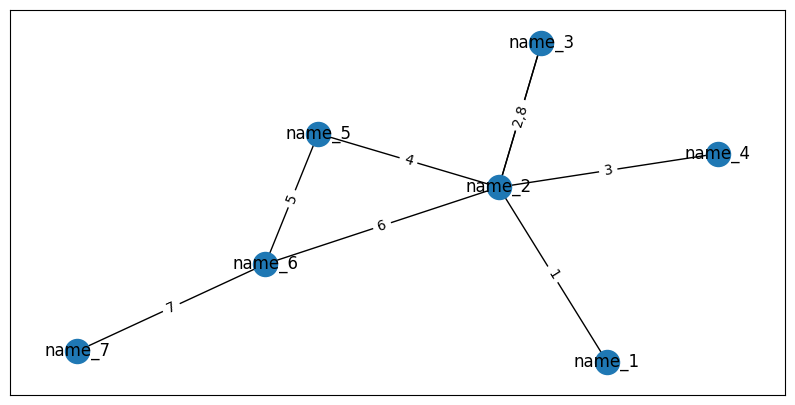

In [93]:
g = get_graph()
iaa = IntActAnalyzer(g)
iaa.draw_graph(node_label='name')

In [96]:
neighbors = [i for i in g.neighbors(2)]
neighbors

[1, 3, 4, 5, 6]

In [102]:
dict(g.nodes(data=True))

{1: {'accession': 'node_id1', 'name': 'name_1', 'taxid': 1},
 2: {'accession': 'node_id2', 'name': 'name_2', 'taxid': 1},
 3: {'accession': 'node_id3', 'name': 'name_3', 'taxid': 1},
 4: {'accession': 'node_id4', 'name': 'name_4', 'taxid': 1},
 5: {'accession': 'node_id5', 'name': 'name_5', 'taxid': 1},
 6: {'accession': 'node_id6', 'name': 'name_6', 'taxid': 2},
 7: {'accession': 'node_id7', 'name': 'name_7', 'taxid': 1}}

In [115]:
def get_neighbors_name(name,graph):
    nodes = dict(graph.nodes(data=True))
    for node,data in nodes.items():
        if data["name"] == name:
            neighbors = [n for n in graph.neighbors(node)]
            name_neighbors = [graph.nodes[n]["name"] for n in neighbors]
    return name_neighbors

dct = nw.betweenness_centrality(g)
sorted(dct.items(), key = lambda x: x[1])[-1][0]


2

In [108]:
get_neighbors_name("name_5",g)

['name_2', 'name_6']

In [116]:
def get_protein_with_highest_bc(graph):
    dct = nx.betweenness_centrality(g)
    node = sorted(dct.items(), key = lambda x: x[1])[-1]
    data = graph.nodes[node[0]]
    data["node_id"] = node[0]
    data["bc_value"] = node[1]
    return data

get_protein_with_highest_bc(g)

{'accession': 'node_id2',
 'name': 'name_2',
 'taxid': 1,
 'node_id': 2,
 'bc_value': 0.8}